In [1]:
import argparse
import json
import os
import pathlib
import zipfile
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
import tensorflow_hub as hub
from tqdm import tqdm, trange

imagenet_path = '/home/vista/Datasets/ILSVRC/Data/CLS-LOC'
#imagenet_path = '/home/chaimb/ILSVRC/Data/CLS-LOC'
objectnet_path = '/home/chaimb/objectnet-1.0'


In [2]:
def download_file(url, filename=False, verbose=False):
    """
    Download file with progressbar

    Usage:
        download_file('http://web4host.net/5MB.zip')
    """
    if not filename:
        local_filename = os.path.join(".", url.split('/')[-1])
    else:
        local_filename = filename

    response = requests.get(url, stream=True)

    with open(filename, "wb") as handle:
        for data in tqdm(response.iter_content()):
            handle.write(data)
    return


In [3]:
# test
IMAGE_SHAPE = (224, 224)
train_dir = pathlib.Path(os.path.join(imagenet_path, 'train'))
val_dir = pathlib.Path(os.path.join(imagenet_path, 'val'))
object_dir = pathlib.Path(os.path.join(objectnet_path, 'images'))

In [4]:
assert val_dir.exists()
assert train_dir.exists()

In [5]:
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES_OBJ = np.array([item.name for item in object_dir.glob('*') if item.name != "LICENSE.txt"])

In [6]:

map_url = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
response = json.loads(requests.get(map_url).text)
name_map = {}
name_to_num = {}
for r in response:
    name_map[response[r][0]] = response[r][1]
    name_to_num[response[r][1]] = response[r][0]


In [7]:

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        plt.title(name_map[CLASS_NAMES[label_batch[n] == 1][0].title().lower()])
        plt.axis('off')


In [8]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES


def get_label_objectnet(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES_OBJ

def crop_center_and_resize(img, size, scale=0.875):
    s = tf.shape(img)
    w, h = s[0], s[1]
    c = tf.maximum(w, h)
    wn, hn = h / c * scale, w / c * scale
    result = tf.image.crop_and_resize(tf.expand_dims(img, 0),
                                      [[(1 - wn) / 2, (1 - hn) / 2, wn, hn]],
                                      [0], [size, size])
    return tf.squeeze(result, 0)

def decode_img(img, IMG_HEIGHT=224, IMG_WIDTH=224, pm1=False, crop=True):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    if pm1:
        img = tf.cast(img, tf.float32) / (255. / 2.) - 1
    else:
        img = tf.image.convert_image_dtype(img, tf.float32)
    if IMG_HEIGHT == 256:
        SIZE = 292
    else:
        SIZE = 256
    # resize the image to the desired size.
    if crop:
        return crop_center_and_resize(img,IMG_HEIGHT)
    else:
        return tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_HEIGHT)


def process_path(file_path, bbg=False, label_function=get_label, crop=True):
    label = label_function(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    if bbg:
        img = decode_img(img, 256, 256, True, crop=crop)
    else:
        img = decode_img(img, crop=crop)
    return img, label


def prepare_for_eval(ds, batch_size):
    ds = ds.batch(batch_size)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=640)

    return ds


In [9]:

def get_datasets(bbg=False):
    BATCH_SIZE = 32
    process = partial(process_path, bbg=bbg, label_function=get_label)
    process_obj = partial(process_path, bbg=bbg, label_function=get_label_objectnet)

    list_ds = tf.data.Dataset.list_files(str(train_dir / '*/*'), shuffle=False)
    # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
    labeled_ds = list_ds.map(process, num_parallel_calls=8)

    train_ds = prepare_for_eval(labeled_ds, BATCH_SIZE)

    list_val_ds = tf.data.Dataset.list_files(str(val_dir / '*/*'), shuffle=False)
    # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
    labeled_val_ds = list_val_ds.map(process, num_parallel_calls=8)

    val_ds = prepare_for_eval(labeled_val_ds, BATCH_SIZE)
    return train_ds, val_ds


In [10]:
def get_resnet50x4_simclr():
    resnet50x4_url = "https://storage.cloud.google.com/simclr-gcs/checkpoints/ResNet50_1x.zip"

    os.makedirs('./checkpoints', exist_ok=True)

    resnet50x4_path = './checkpoints/checkpoints_ResNet50_4x'
    # download_file(resnet50_url,resnet50_path+'.zip')
    with zipfile.ZipFile(resnet50x4_path + '.zip', "r") as zip_ref:
        zip_ref.extractall('./checkpoints')

    resnet50x4_path = './checkpoints/ResNet50_4x'
    resnet50x4 = tf.keras.Sequential([
        hub.KerasLayer(os.path.join(resnet50x4_path, 'hub'))
    ])

    return resnet50x4


In [11]:
def get_resnet50_simclr():
    resnet50_url = "https://storage.cloud.google.com/simclr-gcs/checkpoints/ResNet50_1x.zip"

    os.makedirs('./checkpoints', exist_ok=True)

    resnet50_path = './checkpoints/ResNet50_1x'
    # download_file(resnet50_url,resnet50_path+'.zip')
    with zipfile.ZipFile(resnet50_path + '.zip', "r") as zip_ref:
        zip_ref.extractall('./checkpoints')

    resnet50 = tf.keras.Sequential([
        hub.KerasLayer(os.path.join(resnet50_path, 'hub'))
    ])

    return resnet50


In [12]:
def get_resnet152x3_simclrv2():
    module_path = 'gs://simclr-checkpoints/simclrv2/pretrained/r152_3x_sk1/hub/'  # r152_3x_sk1
    resnet152x3 = tf.keras.Sequential([
        hub.KerasLayer(module_path)
    ])
    return resnet152x3


def get_resnet50_simclrv2():
    module_path = 'gs://simclr-checkpoints/simclrv2/pretrained/r50_1x_sk0/hub/'  # r152_3x_sk1
    resnet152x3 = tf.keras.Sequential([
        hub.KerasLayer(module_path)
    ])
    return resnet152x3


def get_resnet152_simclrv2():
    module_path = 'gs://simclr-checkpoints/simclrv2/pretrained/r152_1x_sk1/hub/'  # r152_3x_sk1
    resnet152x3 = tf.keras.Sequential([
        hub.KerasLayer(module_path)
    ])
    return resnet152x3


In [13]:
def get_revnet50x4_bigbigan():
    module_path = 'https://tfhub.dev/deepmind/bigbigan-revnet50x4/1'  # RevNet-50 x4
    revnet50x4 = tf.keras.Sequential([
        hub.KerasLayer(module_path, signature='encode')
    ])

    return revnet50x4


def get_resnet50_bigbigan():
    module_path = 'https://tfhub.dev/deepmind/bigbigan-resnet50/1'  # ResNet-50
    resnet50 = tf.keras.Sequential([
        hub.KerasLayer(module_path, signature='encode')
    ])

    return resnet50


In [14]:
models = ['resnet50_simclr', 'resnet50x4_simclr', 'revnet50x4_bigbigan', 'resnet50_simclr2', 'resnet152_simclr2',
          'resnet152x3_simclr2']


def get_model(model='resnet50_simclr'):
    if model == 'resnet50_simclr':
        return get_resnet50_simclr()
    elif model == 'resnet50x4_simclr':
        return get_resnet50x4_simclr()
    elif model == 'revnet50x4_bigbigan':
        return get_revnet50x4_bigbigan()
    elif model == 'resnet50_bigbigan':
        return get_resnet50_bigbigan()
    elif model == 'resnet50_simclr2':
        return get_resnet50_simclrv2()
    elif model == 'resnet152_simclr2':
        return get_resnet152_simclrv2()
    elif model == 'resnet152x3_simclr2':
        return get_resnet152x3_simclrv2()
    else:
        raise ValueError('Wrong model')


In [15]:
def eval(model, ds):
    dit = iter(ds)
    reses = []
    labs = []
    num_elements = tf.data.experimental.cardinality(ds).numpy()
    for ind in trange(num_elements):
        x, y = next(dit)
        result = model.predict_on_batch(x)  # , training=False
        reses.append(result)
        labs.append(y)
    rss = np.concatenate(reses, axis=0)
    lbs = np.concatenate(labs, axis=0)
    return rss, lbs


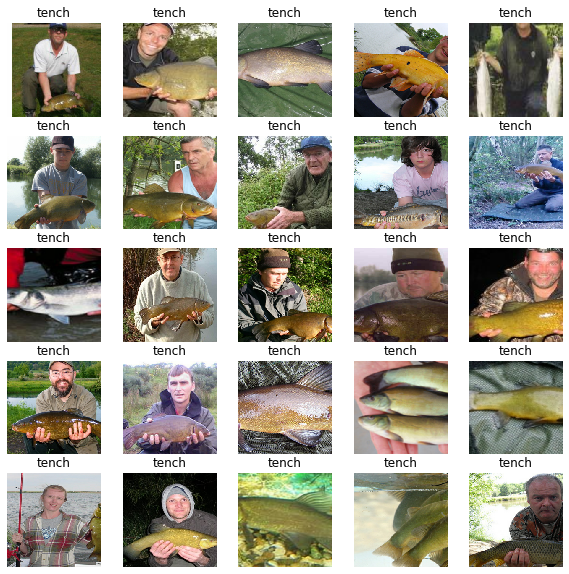

In [16]:
train_ds, val_ds = get_datasets(bbg=False)
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [17]:
list_ds = tf.data.Dataset.list_files(str(val_dir / '*/*'), shuffle=False)

In [18]:
next(iter(list_ds)).numpy()

b'/home/vista/Datasets/ILSVRC/Data/CLS-LOC/val/n01440764/ILSVRC2012_val_00000293.JPEG'

In [19]:
file_list = np.array([x.numpy() for x in iter(list_ds)])

In [20]:
file_list[np.array([0,12,17])]

array([b'/home/vista/Datasets/ILSVRC/Data/CLS-LOC/val/n01440764/ILSVRC2012_val_00000293.JPEG',
       b'/home/vista/Datasets/ILSVRC/Data/CLS-LOC/val/n01440764/ILSVRC2012_val_00011993.JPEG',
       b'/home/vista/Datasets/ILSVRC/Data/CLS-LOC/val/n01440764/ILSVRC2012_val_00017699.JPEG'],
      dtype='|S83')

In [21]:
num_elements = tf.data.experimental.cardinality(train_ds).numpy()
print(num_elements)
num_elements = tf.data.experimental.cardinality(val_ds).numpy()
print(num_elements)


40037
1563


In [22]:
from PIL import Image

def join_images(*rows, bg_color=(0, 0, 0, 0), alignment=(0.5, 0.5)):
    rows = [
        [Image.fromarray((image*255).astype(np.uint8)).convert('RGBA') for image in row]
        for row
        in rows
    ]

    heights = [
        max(image.height for image in row)
        for row
        in rows
    ]

    widths = [
        max(image.width for image in column)
        for column
        in zip(*rows)
    ]

    tmp = Image.new(
        'RGBA',
        size=(sum(widths), sum(heights)),
        color=bg_color
    )

    for i, row in enumerate(rows):
        for j, image in enumerate(row):
            y = sum(heights[:i]) + int((heights[i] - image.height) * alignment[1])
            x = sum(widths[:j]) + int((widths[j] - image.width) * alignment[0])
            tmp.paste(image, (x, y))

    return tmp

def resize(infile, size):
    size = (size,size) if isinstance(size,int) else size
    outfile = os.path.splitext(infile)[0] + str(size[0]) + '.png'
    if infile != outfile:
        im = Image.open(infile)
        im.thumbnail(size, Image.ANTIALIAS)
        im.save(outfile, "png")

In [23]:
def show_images(dr, idx, filename='cluster.png', folder='cluster_vis'):
    list_ds = tf.data.Dataset.list_files(str(dr / '*/*'), shuffle=False)
    file_list = np.array([x.numpy() for x in iter(list_ds)])
    files = file_list[np.array([idx])].squeeze()
    images = []
    for f in files:
        im, _ = process_path(f, bbg=False, label_function=get_label)
        images.append(im.numpy())
        
    im = images[0]
    #print((im.numpy()*255).astype(int))
    #print(Image.fromarray((im.numpy()*255).astype(int)))
    side = int(np.ceil(np.sqrt(len(images))))
    while len(images)<side**2:
        images.append(np.ones_like(images[0]))
    images_sq = []
    for i in range(0,len(images),side):
        images_sq.append(images[i:i+side])
    tmp = join_images(*images_sq, bg_color=(0, 0, 0, 0), alignment=(0.5, 0.5))
    filename = os.path.join(folder, filename)
    tmp.save(filename)
    resize(filename, 1024)
    return
    

In [24]:
show_images(val_dir, np.random.randint(50000, size=(256,)))

In [25]:
def eval_and_save(model='resnet50_simclr'):
    mdl = get_model(model)
    train_embs, train_labs = eval(mdl, train_ds)
    val_embs, val_labs = eval(mdl, val_ds)
    obj_embs, obj_labs = eval(mdl, obj_ds)
    os.makedirs('./results', exist_ok=True)
    np.savez(os.path.join('./results', model + '.npz'), train_embs=train_embs, train_labs=train_labs, val_embs=val_embs,
             val_labs=val_labs, obj_embs=obj_embs, obj_labs=obj_labs)


# eval_and_save(model)

In [26]:
# best cluster i-i #1
show_images(val_dir, np.array([49750,49751,49752,49753,49754,49755,49756,49757,49758,49759,49760,49761
,49762,49763,49764,49765,49766,49767,49768,49769,49770,49771,49772,49773
,49774,49775,49776,49777,49778,49779,49780,49781,49782,49783,49784,49785
,49786,49787,49788,49789,49790,49791,49792,49793,49794,49795,49796,49797
,49798,49799]), 'cluster_best_ii0.png')
# best cluster i-i #2
show_images(val_dir, np.array([49300,49301,49302,49303,49304,49305,49306,49307,49308,49309,49310,49311
,49312,49313,49314,49315,49316,49317,49318,49319,49320,49321,49322,49323
,49324,49325,49326,49328,49329,49330,49331,49332,49333,49334,49335,49336
,49337,49338,49339,49340,49341,49342,49343,49344,49345,49346,49347,49348
,49349]), 'cluster_best_ii1.png')
# best cluster i-i #3
show_images(val_dir, np.array([4350,4351,4352,4353,4354,4355,4356,4357,4358,4359,4360,4361,4362,4363
,4364,4365,4366,4367,4368,4369,4370,4371,4372,4373,4374,4376,4377,4378
,4379,4380,4381,4382,4383,4384,4385,4386,4387,4389,4390,4391,4392,4393
,4394,4395,4396,4397,4399]), 'cluster_best_ii2.png')

In [27]:
# worst cluster i-i #1
show_images(val_dir, np.array([51,80,112,219,1494,2207,2653,3135,3561,4238,4375,4744
,4824,5173,5184,5622,5886,6203,6244,6328,7374,10154,11733,14108
,15345,15601,15751,15783,19668,20463,20527,20633,20635,20647,20648,20673
,20705,20744,20767,20798,20932,20993,21038,21082,21104,21406,21440,21511
,21909,22351,22362,22363,22373,22376,22384,22389,22399,22502,22506,22508
,22510,22515,22518,22520,22521,22525,22528,22529,22531,22532,22536,22539
,22542,22548,22620,22647,22656,22751,23073,23078,23176,23210,23211,23238
,23239,23409,23417,23503,23514,23556,23761,23782,23787,23864,23905,23929
,23933,23942,24046,24075,24082,24096,24264,24551,24706,24721,24818,24822
,24953,24963,24973,24974,24976,24998,25082,25099,25101,25108,25139,25224
,25290,25328,25340,25391,25442,25556,25600,25703,25732,25751,25825,25830
,25832,25920,25925,25968,25992,26138,26173,26207,26229,26235,26309,26409
,26422,26512,26538,26563,26720,26722,26849,27052,27136,27143,27170,27174
,27194,27240,27274,27469,27571,27639,27681,27849,27931,27974,28147,28196
,28353,28386,28518,28706,28994,29023,29091,29326,29352,29374,29387,29427
,29445,29450,29455,29461,29468,29482,29545,29605,29810,29844,29848,29869
,29966,30004,30010,30018,30041,30043,30282,30306,30339,30349,30492,30675
,30678,30685,30902,30955,30961,30964,30968,30977,31063,31138,31147,31153
,31160,31322,31368,31380,31408,31474,31631,31650,31654,31696,31770,31783
,31791,31898,32007,32176,32227,32245,32361,32386,32516,32529,32663,32802
,32810,33073,33104,33106,33123,33127,33146,33604,33651,33652,33681,33700
,33705,33714,33715,33726,33865,33870,33883,33983,34022,34082,34208,34300
,34392,34507,34550,34559,34578,34586,34602,34609,34625,34736,34821,34825
,34828,34844,35021,35201,35257,35383,35422,35471,35492,35502,35503,35516
,35528,35531,35534,35539,35548,35973,36030,36110,36163,36304,36324,36333
,36336,36400,36402,36409,36419,36433,36454,36463,36522,36568,36588,36886
,37002,37010,37020,37043,37078,37080,37116,37217,37239,37247,37259,37272
,37294,37351,37355,37361,37370,37381,37395,37451,37460,37474,37481,37622
,37645,37666,37672,37775,37794,37825,37843,37852,37900,37921,37931,38077
,38238,38249,38464,38500,38606,38633,38644,38684,38710,38747,38901,38938
,38941,39203,39204,39207,39230,39234,39248,39250,39251,39257,39260,39267
,39271,39273,39276,39277,39283,39287,39294,39295,39323,39346,39350,39363
,39366,39372,39388,39393,39408,39589,39639,39701,39738,39742,39901,39957
,39982,40057,40147,40202,40222,40228,40246,40350,40368,40409,40653,40674
,40675,40676,40835,40842,40909,40914,40938,40942,40945,41294,41317,41366
,41371,41503,41519,41530,41805,41809,41850,41886,42046,42071,42181,42241
,42282,42318,42327,42336,42346,42360,42547,42589,42762,42922,42980,42992
,43019,43059,43078,43093,43098,43119,43147,43302,43402,43416,43437,43440
,43446,43609,43640,43753,43880,43940,43953,43962,43975,43990,43999,44056
,44101,44102,44103,44105,44128,44170,44182,44187,44266,44269,44274,44278
,44379,44479,44562,44598,44691,44765,44785,44866,44900,44901,44947,44948
,44956,44990,45004,45195,45339,45358,45531,45937,45949,45988,46000,46031
,46278,46453,46486,46629,46801,46937,46992,47024,47130,47143,47475,47527
,47563,47714,47770,48031,48070,48073,48136,48302,48345,48900,49129,49155
,49162,49166,49392,49950,49971,49975,49984,49986,49997]), 'cluster_worst_ii0.png')
# worst cluster i-i #3
show_images(val_dir, np.array([733,738,748,749,774,797,804,814,816,818,825,832
,838,850,862,870,871,872,873,876,878,879,881,912
,925,934,939,947,962,1366,2876,3494,3714,3771,3799,3953
,4031,4800,5815,6047,6766,6804,6879,6900,7049,7239,7245,7862
,10325,10740,10759,10862,12752,13528,14633,15142,15428,15597,15601,15654
,15655,16483,16547,16854,17020,17298,17697,17927,19285,19957,21034,22465
,22646,23733,23744,23767,24225,24848,26277,26286,26374,26414,27003,27800
,29738,30450,30510,30578,30629,32900,32968,32989,33000,33428,34735,35314
,35487,36044,36617,37701,38798,39174,39629,39909,42066,42697,42763,43527
,44428,44437,46639,46874,46928,48908,48947,48961,49052,49080,49448,49739
,49914]), 'cluster_worst_ii1.png')
# worst cluster i-i #2
show_images(val_dir, np.array([403,714,1170,1195,2563,3373,4075,4408,4670,4984,5080,5231
,5232,6177,6355,6618,6635,7552,7785,8508,8855,9436,9445,11966
,12010,12869,13372,13512,13544,13693,14507,14813,16354,16701,16737,16778
,17057,17319,17379,17639,17653,17688,17750,18276,18420,18439,18786,18787
,18795,19048,19151,19185,19313,19322,19339,19449,19560,19945,20032,20296
,20530,20543,20656,21411,21443,21506,22109,22118,22129,22253,22404,22412
,22429,22817,22826,22848,23014,23142,23156,23465,24447,24461,24468,24472
,24550,24555,24583,24595,24736,24890,25019,25069,25079,25555,25729,25867
,26120,26147,26278,26456,26871,26884,27224,27468,27824,27960,27968,27971
,28119,28128,28755,28872,28908,28917,28923,28930,29029,29181,29189,29805
,29822,29825,30080,30120,30179,30199,30495,30832,31737,31864,31867,32323
,32324,32344,32476,32651,32677,32697,33027,33041,33586,33592,33622,34106
,34121,34480,34702,34862,35154,35155,35157,35164,35170,35171,35172,35174
,35181,35182,35188,35195,35196,35204,35288,35302,35308,35312,35334,35378
,35434,35435,35444,36440,36574,36582,36652,36669,36670,37379,37929,38236
,38253,38273,38322,38605,38609,38779,39080,39626,39685,40124,40139,40359
,40753,41147,41279,41286,41289,41548,41638,41722,41728,41742,41788,41873
,41964,41970,41977,41982,41990,42161,42179,42367,42826,42864,43053,43113
,43161,43193,43206,43321,43485,43801,43805,43965,43967,44005,44010,44427
,44467,44522,44556,44939,45351,45604,45770,45987,46017,46024,46044,47913
,48521,48766,48786,49102,49125,49136,49217,49805]), 'cluster_worst_ii2.png')

In [28]:
# best cluster o-i #1
show_images(val_dir, np.array([262,1253,1381,1483,1512,1520,1537,1594,1621,1690,1724,1738
,1797,1838,1943,2113,2206,2510,2522,2556,2633,2900,2939,2950
,3005,3105,3144,3227,3360,3441,3458,3482,4842,4869,4963,5052
,5195,5360,5389,5390,5395,5398,5429,5459,5611,5619,5698,5708
,5747,5827,5837,5840,5847,5856,5894,5967,6052,6150,6186,6188
,6222,6233,6247,6253,6304,6317,6320,6323,6342,6344,7370,15052
,15085,15273,15329,15457,15466,15536,15726,15737,15749,15894,16471,16506
,16908,17214,17522,18023,19512,19647,19702,19734,19860,19919,20503,20504
,20506,20509,20520,20525,20526,20535,20540,20541,20545,20549,20604,21417
,21430,21765,22049,22416,22432,22914,23094,23147,23241,23382,24152,24409
,24435,24441,24497,24572,24606,24626,24640,24952,24971,24975,24982,24993
,25080,25095,25307,25314,25463,25711,25735,26185,26230,26244,26284,26541
,26745,27630,28391,28509,29209,29213,29214,29351,29379,29398,29803,29812
,29819,29823,29829,29830,29837,29953,29954,29956,29957,29967,29975,29976
,30017,30256,30912,30931,30932,30946,31155,31508,31639,31653,31814,32011
,32310,33318,33713,33838,33878,33893,34312,34340,34790,34800,34801,34812
,34960,34994,35031,35416,36263,36305,36315,36332,36429,36431,36444,36562
,36565,36912,36942,36983,36984,37044,37071,37433,37459,37465,37659,37689
,37805,37901,37909,37923,37926,37927,38233,38319,38422,38715,38798,38907
,38921,39240,39611,39615,39634,39645,40267,40363,40443,40568,40652,40659
,40778,41284,41338,41361,41520,41668,41779,41780,42013,42021,42167,42169
,42527,42631,43082,43125,43266,43415,43418,43521,43951,43976,43989,44090
,44193,44229,44289,44419,44560,44629,44651,44912,44982,45390,45622,45873
,46052,46469,46568,46605,46623,47000,47025,47158,47453,47613,47644,47778
,47882,47915,48058,48194,48555,48741,48908,48937,49020,49575,49694,49702
,49731,49814,49823,49849]), 'cluster_best_oi0.png')
# best cluster o-i #2
show_images(val_dir, np.array([51,80,112,219,1494,2207,2653,3135,3561,4238,4375,4744
,4824,5173,5184,5622,5886,6203,6244,6328,7374,10154,11733,14108
,15345,15601,15751,15783,19668,20463,20527,20633,20635,20647,20648,20673
,20705,20744,20767,20798,20932,20993,21038,21082,21104,21406,21440,21511
,21909,22351,22362,22363,22373,22376,22384,22389,22399,22502,22506,22508
,22510,22515,22518,22520,22521,22525,22528,22529,22531,22532,22536,22539
,22542,22548,22620,22647,22656,22751,23073,23078,23176,23210,23211,23238
,23239,23409,23417,23503,23514,23556,23761,23782,23787,23864,23905,23929
,23933,23942,24046,24075,24082,24096,24264,24551,24706,24721,24818,24822
,24953,24963,24973,24974,24976,24998,25082,25099,25101,25108,25139,25224
,25290,25328,25340,25391,25442,25556,25600,25703,25732,25751,25825,25830
,25832,25920,25925,25968,25992,26138,26173,26207,26229,26235,26309,26409
,26422,26512,26538,26563,26720,26722,26849,27052,27136,27143,27170,27174
,27194,27240,27274,27469,27571,27639,27681,27849,27931,27974,28147,28196
,28353,28386,28518,28706,28994,29023,29091,29326,29352,29374,29387,29427
,29445,29450,29455,29461,29468,29482,29545,29605,29810,29844,29848,29869
,29966,30004,30010,30018,30041,30043,30282,30306,30339,30349,30492,30675
,30678,30685,30902,30955,30961,30964,30968,30977,31063,31138,31147,31153
,31160,31322,31368,31380,31408,31474,31631,31650,31654,31696,31770,31783
,31791,31898,32007,32176,32227,32245,32361,32386,32516,32529,32663,32802
,32810,33073,33104,33106,33123,33127,33146,33604,33651,33652,33681,33700
,33705,33714,33715,33726,33865,33870,33883,33983,34022,34082,34208,34300
,34392,34507,34550,34559,34578,34586,34602,34609,34625,34736,34821,34825
,34828,34844,35021,35201,35257,35383,35422,35471,35492,35502,35503,35516
,35528,35531,35534,35539,35548,35973,36030,36110,36163,36304,36324,36333
,36336,36400,36402,36409,36419,36433,36454,36463,36522,36568,36588,36886
,37002,37010,37020,37043,37078,37080,37116,37217,37239,37247,37259,37272
,37294,37351,37355,37361,37370,37381,37395,37451,37460,37474,37481,37622
,37645,37666,37672,37775,37794,37825,37843,37852,37900,37921,37931,38077
,38238,38249,38464,38500,38606,38633,38644,38684,38710,38747,38901,38938
,38941,39203,39204,39207,39230,39234,39248,39250,39251,39257,39260,39267
,39271,39273,39276,39277,39283,39287,39294,39295,39323,39346,39350,39363
,39366,39372,39388,39393,39408,39589,39639,39701,39738,39742,39901,39957
,39982,40057,40147,40202,40222,40228,40246,40350,40368,40409,40653,40674
,40675,40676,40835,40842,40909,40914,40938,40942,40945,41294,41317,41366
,41371,41503,41519,41530,41805,41809,41850,41886,42046,42071,42181,42241
,42282,42318,42327,42336,42346,42360,42547,42589,42762,42922,42980,42992
,43019,43059,43078,43093,43098,43119,43147,43302,43402,43416,43437,43440
,43446,43609,43640,43753,43880,43940,43953,43962,43975,43990,43999,44056
,44101,44102,44103,44105,44128,44170,44182,44187,44266,44269,44274,44278
,44379,44479,44562,44598,44691,44765,44785,44866,44900,44901,44947,44948
,44956,44990,45004,45195,45339,45358,45531,45937,45949,45988,46000,46031
,46278,46453,46486,46629,46801,46937,46992,47024,47130,47143,47475,47527
,47563,47714,47770,48031,48070,48073,48136,48302,48345,48900,49129,49155
,49162,49166,49392,49950,49971,49975,49984,49986,49997]), 'cluster_best_oi1.png')
# best cluster o-i #3
show_images(val_dir, np.array([559,573,577,600,603,605,618,638,639,642,643,669
,697,716,720,725,753,765,766,767,771,772,776,777
,787,788,792,798,801,812,821,823,829,831,834,836
,837,840,841,847,849,855,871,875,920,942,1049,1066
,1069,2766,4042,4335,4572,4574,4600,4618,4671,4697,4747,4748
,6314,6485,6552,6720,6788,7064,7321,16109,19660,47303,49432,49738
,49947]), 'cluster_best_oi2.png')

In [29]:
# worst cluster i-i #1
show_images(val_dir, np.array([51,80,112,219,1494,2207,2653,3135,3561,4238,4375,4744
,4824,5173,5184,5622,5886,6203,6244,6328,7374,10154,11733,14108
,15345,15601,15751,15783,19668,20463,20527,20633,20635,20647,20648,20673
,20705,20744,20767,20798,20932,20993,21038,21082,21104,21406,21440,21511
,21909,22351,22362,22363,22373,22376,22384,22389,22399,22502,22506,22508
,22510,22515,22518,22520,22521,22525,22528,22529,22531,22532,22536,22539
,22542,22548,22620,22647,22656,22751,23073,23078,23176,23210,23211,23238
,23239,23409,23417,23503,23514,23556,23761,23782,23787,23864,23905,23929
,23933,23942,24046,24075,24082,24096,24264,24551,24706,24721,24818,24822
,24953,24963,24973,24974,24976,24998,25082,25099,25101,25108,25139,25224
,25290,25328,25340,25391,25442,25556,25600,25703,25732,25751,25825,25830
,25832,25920,25925,25968,25992,26138,26173,26207,26229,26235,26309,26409
,26422,26512,26538,26563,26720,26722,26849,27052,27136,27143,27170,27174
,27194,27240,27274,27469,27571,27639,27681,27849,27931,27974,28147,28196
,28353,28386,28518,28706,28994,29023,29091,29326,29352,29374,29387,29427
,29445,29450,29455,29461,29468,29482,29545,29605,29810,29844,29848,29869
,29966,30004,30010,30018,30041,30043,30282,30306,30339,30349,30492,30675
,30678,30685,30902,30955,30961,30964,30968,30977,31063,31138,31147,31153
,31160,31322,31368,31380,31408,31474,31631,31650,31654,31696,31770,31783
,31791,31898,32007,32176,32227,32245,32361,32386,32516,32529,32663,32802
,32810,33073,33104,33106,33123,33127,33146,33604,33651,33652,33681,33700
,33705,33714,33715,33726,33865,33870,33883,33983,34022,34082,34208,34300
,34392,34507,34550,34559,34578,34586,34602,34609,34625,34736,34821,34825
,34828,34844,35021,35201,35257,35383,35422,35471,35492,35502,35503,35516
,35528,35531,35534,35539,35548,35973,36030,36110,36163,36304,36324,36333
,36336,36400,36402,36409,36419,36433,36454,36463,36522,36568,36588,36886
,37002,37010,37020,37043,37078,37080,37116,37217,37239,37247,37259,37272
,37294,37351,37355,37361,37370,37381,37395,37451,37460,37474,37481,37622
,37645,37666,37672,37775,37794,37825,37843,37852,37900,37921,37931,38077
,38238,38249,38464,38500,38606,38633,38644,38684,38710,38747,38901,38938
,38941,39203,39204,39207,39230,39234,39248,39250,39251,39257,39260,39267
,39271,39273,39276,39277,39283,39287,39294,39295,39323,39346,39350,39363
,39366,39372,39388,39393,39408,39589,39639,39701,39738,39742,39901,39957
,39982,40057,40147,40202,40222,40228,40246,40350,40368,40409,40653,40674
,40675,40676,40835,40842,40909,40914,40938,40942,40945,41294,41317,41366
,41371,41503,41519,41530,41805,41809,41850,41886,42046,42071,42181,42241
,42282,42318,42327,42336,42346,42360,42547,42589,42762,42922,42980,42992
,43019,43059,43078,43093,43098,43119,43147,43302,43402,43416,43437,43440
,43446,43609,43640,43753,43880,43940,43953,43962,43975,43990,43999,44056
,44101,44102,44103,44105,44128,44170,44182,44187,44266,44269,44274,44278
,44379,44479,44562,44598,44691,44765,44785,44866,44900,44901,44947,44948
,44956,44990,45004,45195,45339,45358,45531,45937,45949,45988,46000,46031
,46278,46453,46486,46629,46801,46937,46992,47024,47130,47143,47475,47527
,47563,47714,47770,48031,48070,48073,48136,48302,48345,48900,49129,49155
,49162,49166,49392,49950,49971,49975,49984,49986,49997]), 'cluster_worst_oi0.png')
# worst cluster i-i #3
show_images(val_dir, np.array([733,738,748,749,774,797,804,814,816,818,825,832
,838,850,862,870,871,872,873,876,878,879,881,912
,925,934,939,947,962,1366,2876,3494,3714,3771,3799,3953
,4031,4800,5815,6047,6766,6804,6879,6900,7049,7239,7245,7862
,10325,10740,10759,10862,12752,13528,14633,15142,15428,15597,15601,15654
,15655,16483,16547,16854,17020,17298,17697,17927,19285,19957,21034,22465
,22646,23733,23744,23767,24225,24848,26277,26286,26374,26414,27003,27800
,29738,30450,30510,30578,30629,32900,32968,32989,33000,33428,34735,35314
,35487,36044,36617,37701,38798,39174,39629,39909,42066,42697,42763,43527
,44428,44437,46639,46874,46928,48908,48947,48961,49052,49080,49448,49739
,49914,50071]), 'cluster_worst_oi1.png')
# worst cluster i-i #2
show_images(val_dir, np.array([5561,5572,5573,5581,5591,5594,5595]), 'cluster_worst_oi2.png')

IndexError: index 50071 is out of bounds for axis 0 with size 50000

In [ ]:
show_images(val_dir, np.array([80,100,299,407,602,913,1410,1552,1597,1754,1772,1868,2261,2285,2330,2380,2484,
                               2605,3242,3317,3604,3754,4321,4346,4392,4714,4913,6198,6366,6388,6664,7158,7295,
                               7469,7789,8217,8423,9482,10284,10493,10719,10903,11224,11365,11664,11693,11894,
                               11990,12002,12120,12188,12498,12774,12822,13028,13189,13227,13566,13767,13808,
                               14164,14183,14317,15079,15132,15343,15647,16092,16121,16139,16177,16251,
                               16411,16560,17146,17188,17357,17373,17696,17736,18117,18574,18591,18702,
                               18822,19048,19200,20196,20584,20624,20838,20977,21042,21631,21728,21844,
                               21989,22036,22126,22222,22273,22583,23449,23476,23625,23632,23659,23674,
                               23927,24201,24271,24545,24551,25351,25427,25493,25707,25866,25890,25934,
                               25973,26132,27448,28043,28517,28521,29045,29137,29321,29489,29497,29601,
                               29716,29717,29789,30038,30068,30427,30554,31154,31440,31895,32185,32535,
                               32883,33551,33725,33826,33974,34140,34343,34357,34391,34461,34632,35122,
                               35347,35369,36043,36102,36225,36296,36499,36594,36742,36770,36897,36981,
                               37037,37201,37222,37326,37333,37552,37884,37932,38322,38591,38770,38953,
                               39593,39625,39732,39761,39943,40257,40605,41182,41319,41405,42046,42085,
                               42613,42777,42842,42912,42969,43350,43354,43389,44182,44446,44573,45503,
                               45594,46414,46635,46825,47043,47068,47565,47696,48078,48542,48683,48934,
                               49020,49312,49352,49517,49660,49892,49993]), 'cluster_worst_super.png')